# A/B test analysis for Cookie Cats Mobile Game

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.

In [1]:
import pandas as pd
# Reading in the data
df = pd.read_csv("datasets/cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

* userid - a unique number that identifies each player.
* version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
* sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
* retention_1 - did the player come back and play 1 day after installing?
* retention_7 - did the player come back and play 7 days after installing?

## A/B Test Data

In [2]:
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

* there is roughly the same number of players in each group

## Distribution of game rounds

Text(0,0.5,'Number of users')

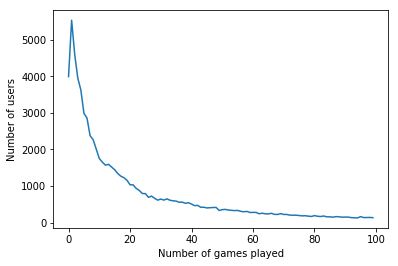

In [3]:
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby(['sum_gamerounds'])['userid'].count()


# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot()
ax.set_xlabel("Number of games played")
ax.set_ylabel("Number of users")

* We can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!

## Overall 1-day retention

* We want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: The percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

In [4]:
print("Overall 1-day retention is:",round(df[df.retention_1 == True]['userid'].count()/df['userid'].count() *100,2),"%")

Overall 1-day retention is: 44.52 %


## 1-day retention by AB-group

In [5]:
df[df.retention_1 == True].groupby('version')['userid'].count()/df[df.retention_1 == True]['userid'].count()

version
gate_30    0.498942
gate_40    0.501058
Name: userid, dtype: float64

## Bootstrapping

* We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

In [6]:
boot_1d = []
for i in range(0,1000):
    boot_mean = df[df['retention_1']==True].sample(frac=1, replace=True).groupby('version')['sum_gamerounds'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)

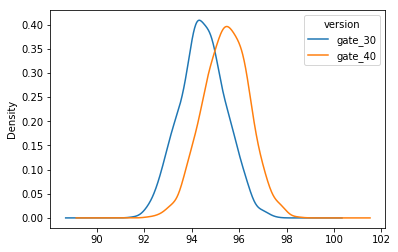

In [7]:
boot_1d.plot.kde()

## Difference between the two groups

Text(0.5,0,'% Difference in mean')

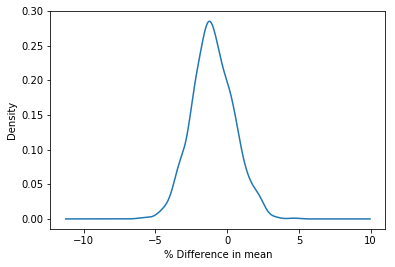

In [8]:
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40 *100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel("% Difference in mean")

## The probability of a difference

In [9]:
prob = (boot_1d['diff']>0).sum()/len(boot_1d['gate_30'])
print("Probability that 1-day retention is greater when the gate is at level 30: ",prob)

Probability that 1-day retention is greater when the gate is at level 30:  0.245


## 7-day retention by AB-group

In [10]:
df[df['retention_7']==True].groupby('version').userid.count()/df[df['retention_7']==True]['userid'].count()

version
gate_30    0.506644
gate_40    0.493356
Name: userid, dtype: float64

## Bootstrapping the difference again

In [11]:
boot_7d = []
for i in range(1000):
    boot_mean = df[df['retention_7']==True].sample(frac=1, replace=True).groupby('version')['sum_gamerounds'].mean()
    boot_7d.append(boot_mean)

Text(0.5,0,'% difference in means')

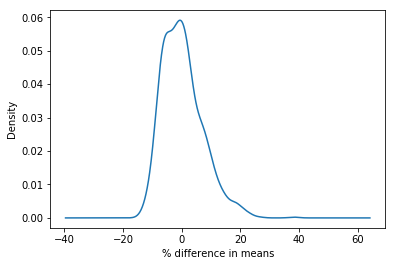

In [17]:
boot_7d = pd.DataFrame(boot_7d)

# ... YOUR CODE FOR TASK 10 ...

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_1d.gate_40 *100


# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% difference in means")

In [18]:
# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff']>0).sum()/len(boot_1d['gate_30'])
print("Probability that 7-day retention is greater when the gate is at level 30:", prob)

Probability that 7-day retention is greater when the gate is at level 30: 0.466
